# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## **Note:** This notebook is part of an in-house Kaggle competition

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1c7PrbKrURFcnEB61dSoS9cBnUUVhhj-l/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.

## Grading = 10 Points

In [229]:
!uv add ipykernel numpy matplotlib scikit-learn seaborn catboost scipy==1.12 xgboost lightgbm --upgrade


Resolved 58 packages in 934ms                                        
Audited 52 packages in 0.56ms


In [230]:
# @title Download the data
from utility import download_if_missing

download_if_missing(
    filename="hr_employee_attrition_train.csv",
    url="https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv",
)

# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")


Data Downloaded Successfuly!!


### Install CatBoost

In [231]:
# !pip -qq install catboost
# !uv add catboost numpy --upgrade


### Import Required Packages

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score,
    classification_report,
)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
import math
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", 100)
%matplotlib inline


## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [233]:
# read the dataset

df = pd.read_csv("hr_employee_attrition_train.csv")


In [234]:
# Check the shape of dataframe.
# YOUR CODE HERE

df.shape


(1170, 35)

There can be more than one file to read as this is introduced as a competition, dataset has one file for training the model. Their can be other files as one containing the test features and the other can be the true labels.

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:** Use `for` to iterate through each column.

In [235]:
# Check the name and the data types of columns.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1170 non-null   int64 
 1   businesstravel            1170 non-null   object
 2   dailyrate                 1170 non-null   int64 
 3   department                1170 non-null   object
 4   distancefromhome          1170 non-null   int64 
 5   education                 1170 non-null   int64 
 6   educationfield            1170 non-null   object
 7   employeecount             1170 non-null   int64 
 8   employeenumber            1170 non-null   int64 
 9   environmentsatisfaction   1170 non-null   int64 
 10  gender                    1170 non-null   object
 11  hourlyrate                1170 non-null   int64 
 12  jobinvolvement            1170 non-null   int64 
 13  joblevel                  1170 non-null   int64 
 14  jobrole                 

In [236]:
# check a random sample from the dataframe
df.sample(10)


age     businesstravel  dailyrate              department  \
19     27      Travel_Rarely        591  Research & Development   
79     40      Travel_Rarely        750  Research & Development   
220    38      Travel_Rarely       1495  Research & Development   
1065   42  Travel_Frequently       1271  Research & Development   
274    31  Travel_Frequently       1445  Research & Development   
976    55      Travel_Rarely        111                   Sales   
308    18  Travel_Frequently        544                   Sales   
443    30  Travel_Frequently        109  Research & Development   
1057   38  Travel_Frequently       1394  Research & Development   
644    24  Travel_Frequently        535                   Sales   

      distancefromhome  education educationfield  employeecount  \
19                   2          1        Medical              1   
79                  12          3  Life Sciences              1   
220                  4          2        Medical              1   
1065                 2          1        Medical              1   
274                  1          5  Life Sciences              1   
976                  1          2  Life Sciences              1   
308                  3          2        Medical              1   
443                  5          3        Medical              1   
1057                 8          3        Medical              1   
644                 24          3        Medical              1   

      employeenumber  environmentsatisfaction  gender  hourlyrate  \
19                 7                        1    Male          40   
79              1829                        2  Female          47   
220             1687                        4  Female          87   
1065             875                        2    Male          35   
274             1459                        3  Female         100   
976              106                        1    Male          70   
308             1624                        2  Female          70   
443             1017                        2  Female          60   
1057            1937                        4  Female          58   
644              632                        4    Male          38   

      jobinvolvement  joblevel                    jobrole  jobsatisfaction  \
19                 3         1      Laboratory Technician                2   
79                 3         2  Healthcare Representative                1   
220                3         1      Laboratory Technician                3   
1065               3         1         Research Scientist                4   
274                4         3     Manufacturing Director                2   
976                3         3            Sales Executive                4   
308                3         1       Sales Representative                4   
443                3         1      Laboratory Technician                2   
1057               2         2         Research Scientist                2   
644                3         1       Sales Representative                4   

     maritalstatus  monthlyincome  monthlyrate  numcompaniesworked over18  \
19         Married           3468        16632                   9      Y   
79        Divorced           4448        10748                   2      Y   
220        Married           3306        26176                   7      Y   
1065        Single           2515         9068                   5      Y   
274         Single           7446         8931                   1      Y   
976        Married          10239        18092                   3      Y   
308         Single           1569        18420                   1      Y   
443         Single           2422        25725                   0      Y   
1057      Divorced           2133        18115                   1      Y   
644        Married           2400         5530                   0      Y   

     overtime  percentsalaryhike  performancerating  relationsh

In [237]:
df.head(n=10)


age     businesstravel  dailyrate              department  \
0   45      Travel_Rarely        556  Research & Development   
1   34      Travel_Rarely        970  Research & Development   
2   39      Travel_Rarely        360  Research & Development   
3   26      Travel_Rarely        933                   Sales   
4   40      Travel_Rarely        329  Research & Development   
5   29      Travel_Rarely        408  Research & Development   
6   57      Travel_Rarely        593  Research & Development   
7   28      Travel_Rarely       1423  Research & Development   
8   33      Travel_Rarely        134  Research & Development   
9   31  Travel_Frequently        667                   Sales   

   distancefromhome  education    educationfield  employeecount  \
0                25          2     Life Sciences              1   
1                 8          2           Medical              1   
2                23          3           Medical              1   
3                 1          3     Life Sciences              1   
4                 1          4     Life Sciences              1   
5                25          5  Technical Degree              1   
6                 1          4           Medical              1   
7                 1          3     Life Sciences              1   
8                 2          3     Life Sciences              1   
9                 1          4     Life Sciences              1   

   employeenumber  environmentsatisfaction  gender  hourlyrate  \
0            1888                        2  Female          93   
1             757                        2  Female          96   
2            1310                        3    Male          93   
3             476                        3    Male          57   
4            1361                        2    Male          88   
5             565                        3  Female          71   
6             482                        4    Male          88   
7            1506                        1    Male          72   
8             242                        3    Male          90   
9            1427                        2  Female          50   

   jobinvolvement  joblevel                    jobrole  jobsatisfaction  \
0               2         2     Manufacturing Director                4   
1               3         2  Healthcare Representative                3   
2               3         1         Research Scientist                1   
3               3         2            Sales Executive                3   
4               3         1      Laboratory Technician                2   
5               2         1         Research Scientist                2   
6               3         2  Healthcare Representative                3   
7               2         1         Research Scientist                3   
8               3         1         Research Scientist                4   
9               1         1       Sales Representative                3   

  maritalstatus  monthlyincome  monthlyrate  numcompaniesworked over18  \
0       Married           5906        23888                   0      Y   
1        Single           6142         7360                   3      Y   
2        Single           3904        22154                   0      Y   
3       Married           5296        20156                   1      Y   
4       Married           2387         6762                   3      Y   
5       Married           2546        18300                   5      Y   
6       Married           6755         2967                   2      Y   
7      Divorced           1563        12530                   1      Y   
8        Single           2500        10515                   0      Y   
9        Single           1359        16154                   1      Y   

  overtime  percentsalaryhike  performancerating  relationshipsatisfaction  \
0       No                 13                  3                         4   
1       No                 11       

In [238]:
categorical_columns_in_seq = [
    "businesstravel",
    "department",
    "education",
    "educationfield",
    "environmentsatisfaction",
    "gender",
    "jobinvolvement",
    "joblevel",
    "jobrole",
    "jobsatisfaction",
    "maritalstatus",
    "numcompaniesworked",
    "over18",
    "overtime",
    "performancerating",
    "relationshipsatisfaction",
    "standardhours",
    "stockoptionlevel",
    "trainingtimeslastyear",
    "worklifebalance",
    "attrition",
]

print(len(categorical_columns_in_seq))


21


In [239]:
# separate the columns as categorical and numerical
# categorical_columns = df.select_dtypes(include=["object"]).columns
# numerical_columns = df.select_dtypes(exclude=["object"]).columns

categorical_ordinal_columns = [
    "education",
    "environmentsatisfaction",
    "jobinvolvement",
    "joblevel",
    "jobsatisfaction",
    "numcompaniesworked",
    "performancerating",
    "relationshipsatisfaction",
    "stockoptionlevel",
    "trainingtimeslastyear",
    "worklifebalance",
]

categorical_nominal_columns = [
    "businesstravel",
    "department",
    "educationfield",
    "gender",
    "jobrole",
    "maritalstatus",
    "over18",
    "overtime",
    "standardhours",
    "attrition",
]
numerical_columns = [
    "age",
    "dailyrate",
    "distancefromhome",
    "hourlyrate",
    "monthlyincome",
    "monthlyrate",
    "percentsalaryhike",
    "totalworkingyears",
    "yearsatcompany",
    "yearsincurrentrole",
    "yearssincelastpromotion",
    "yearswithcurrmanager",
]
useless_columns = ["employeecount", "employeenumber"]

print(
    f"Number of Categorical Columns: {len(categorical_columns_in_seq)} (ordinal= {len(categorical_ordinal_columns)} nominal={len(categorical_nominal_columns)})"
)
print(f"Number of Numerical Columns: {len(numerical_columns)}")
print(f"Number of Useless Columns: {len(useless_columns)}")
print(
    f"Total Columns: {len(categorical_ordinal_columns) + len(categorical_nominal_columns) + len(numerical_columns) + len(useless_columns)}"
)


Number of Categorical Columns: 21 (ordinal= 11 nominal=10)
Number of Numerical Columns: 12
Number of Useless Columns: 2
Total Columns: 35


In [240]:
# Analyze categorical columns in a dataset
## unique values in each column
## count of unique values in each column
## missing values in each column

# Create a dataframe to store the information
df_categorical_info = pd.DataFrame(
    columns=[
        "Column",
        "Unique Values",
        "Count of Unique Values",
        "Missing Values",
        "Data Type",
        "Categorical Type",
    ]
)

# Iterate through each categorical column and collect the required information
for col in categorical_ordinal_columns:
    unique_values = df[col].unique()
    count_unique_values = df[col].nunique()
    missing_values = df[col].isnull().sum()
    unique_val = ", ".join(unique_values.astype(str))
    col_dtype = df[col].dtype
    cat_type = "Ordinal"
    # print(un_val)
    # Append the information to the dataframe
    temp_df = pd.DataFrame(
        {
            "Column": col,
            "Unique Values": [unique_val],
            "Count of Unique Values": count_unique_values,
            "Missing Values": missing_values,
            "Data Type": [col_dtype],
            "Categorical Type": cat_type,
        }
    )

    df_categorical_info = pd.concat([df_categorical_info, temp_df], axis=0)

for col in categorical_nominal_columns:
    unique_values = df[col].unique()
    count_unique_values = df[col].nunique()
    missing_values = df[col].isnull().sum()
    unique_val = ", ".join(unique_values.astype(str))
    col_dtype = df[col].dtype
    cat_type = "Nominal"
    # print(un_val)
    # Append the information to the dataframe
    temp_df = pd.DataFrame(
        {
            "Column": col,
            "Unique Values": [unique_val],
            "Count of Unique Values": count_unique_values,
            "Missing Values": missing_values,
            "Data Type": [col_dtype],
            "Categorical Type": cat_type,
        }
    )

    df_categorical_info = pd.concat([df_categorical_info, temp_df], axis=0)


# Display the dataframe
df_categorical_info


Column  \
0                 education   
0   environmentsatisfaction   
0            jobinvolvement   
0                  joblevel   
0           jobsatisfaction   
0        numcompaniesworked   
0         performancerating   
0  relationshipsatisfaction   
0          stockoptionlevel   
0     trainingtimeslastyear   
0           worklifebalance   
0            businesstravel   
0                department   
0            educationfield   
0                    gender   
0                   jobrole   
0             maritalstatus   
0                    over18   
0                  overtime   
0             standardhours   
0                 attrition   

                                       Unique Values Count of Unique Values  \
0                                      2, 3, 4, 5, 1                      5   
0                                         2, 3, 4, 1                      4   
0                                         2, 3, 1, 4                      4   
0                                      2, 1, 3, 4, 5                      5   
0                                         4, 3, 1, 2                      4   
0                       0, 3, 1, 5, 2, 7, 9, 8, 6, 4                     10   
0                                               3, 4                      2   
0                                         4, 1, 2, 3                      4   
0                                         2, 0, 1, 3                      4   
0                                2, 3, 6, 1, 5, 4, 0                      7   
0                                         2, 3, 4, 1                      4   
0       Travel_Rarely, Travel_Frequently, Non-Travel                      3   
0     Research & Development, Sales, Human Resources                      3   
0  Life Sciences, Medical, Technical Degree, Othe...                      6   
0                                       Female, Male                      2   
0  Manufacturing Director, Healthcare Representat...                      9   
0                          Married, Single, Divorced                      3   
0                                                  Y                      1   
0                                            No, Yes                      2   
0                                                 80                      1   
0                                            No, Yes                      2   

  Missing Values Data Type Categorical Type  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0     int64          Ordinal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0    object          Nominal  
0              0     int64          Nominal  
0              0    object          Nominal

In [241]:
# Analyze numerical columns in a dataset
## mean, median, mode, min, max, range, standard deviation, variance
## missing values in each column

# Create a dataframe to store the information
df_numerical_info = pd.DataFrame(
    columns=[
        "Column",
        "Mean",
        "Median (50th Percentile)",
        "Mode",
        "Min",
        "Max",
        "Range",
        "Standard Deviation",
        "Variance",
        "25th Percentile",
        "50th Percentile (Median)",
        "75th Percentile",
        "Count of Unique Values",
        "Missing Values",
        "Data Type",
    ]
)

# Iterate through each categorical column and collect the required information
for col in numerical_columns:
    mean = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0]
    minimum = df[col].min()
    maximum = df[col].max()
    range_val = maximum - minimum
    std_dev = df[col].std()
    variance = df[col].var()
    missing_values = df[col].isnull().sum()
    percentile_25 = df[col].quantile(0.25)
    percentile_50 = df[col].quantile(0.50)
    percentile_75 = df[col].quantile(0.75)
    count_unique_values = df[col].nunique()
    col_dtype = df[col].dtype
    # Append the information to the dataframe
    temp_df = pd.DataFrame(
        {
            "Column": col,
            "Mean": [mean],
            "Median (50th Percentile)": [median],
            "Mode": [mode],
            "Min": [minimum],
            "Max": [maximum],
            "Range": [range_val],
            "Standard Deviation": [std_dev],
            "Variance": [variance],
            "25th Percentile": [percentile_25],
            "50th Percentile (Median)": [percentile_50],
            "75th Percentile": [percentile_75],
            "Count of Unique Values": count_unique_values,
            "Missing Values": [missing_values],
            "Data Type": [col_dtype],
        }
    )

    df_numerical_info = pd.concat([df_numerical_info, temp_df], axis=0)

# Display the dataframe
df_numerical_info


Column          Mean  Median (50th Percentile)  Mode  \
0                      age     36.858120                      35.0    34   
0                dailyrate    797.822222                     798.0   408   
0         distancefromhome      9.262393                       7.0     1   
0               hourlyrate     65.501709                      66.0    42   
0            monthlyincome   6456.937607                    4903.5  2380   
0              monthlyrate  14411.584615                   14536.0  9150   
0        percentsalaryhike     15.204274                      14.0    11   
0        totalworkingyears     11.315385                      10.0    10   
0           yearsatcompany      6.925641                       5.0     5   
0       yearsincurrentrole      4.170940                       3.0     2   
0  yearssincelastpromotion      2.138462                       1.0     0   
0     yearswithcurrmanager      4.061538                       3.0     2   

    Min    Max  Range  Standard Deviation      Variance  25th Percentile  \
0    18     60     42            9.183448  8.433571e+01            30.00   
0   102   1499   1397          403.592661  1.628870e+05           461.00   
0     1     29     28            8.150868  6.643665e+01             2.00   
0    30    100     70           20.310054  4.124983e+02            48.00   
0  1009  19999  18990         4660.476506  2.172004e+07          2914.75   
0  2094  26999  24905         7078.167743  5.010046e+07          8387.50   
0    11     25     14            3.688952  1.360836e+01            12.00   
0     0     40     40            7.879363  6.208437e+01             6.00   
0     0     40     40            6.232076  3.883878e+01             3.00   
0     0     18     18            3.627880  1.316152e+01             2.00   
0     0     15     15            3.201738  1.025113e+01             0.00   
0     0     17     17            3.586350  1.286191e+01             2.00   

   50th Percentile (Median)  75th Percentile Count of Unique Values  \
0                      35.0            43.00                     43   
0                     798.0          1146.75                    778   
0                       7.0            14.00                     29   
0                      66.0            83.00                     71   
0                    4903.5          8215.25                   1097   
0                   14536.0         20456.25                   1149   
0                      14.0            18.00                     15   
0                      10.0            15.00                     40   
0                       5.0             9.00                     37   
0                       3.0             7.00                     19   
0                       1.0             2.75                     16   
0                       3.0             7.00                     18   

  Missing Values Data Type  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64  
0              0     int64

In [242]:
# Analyze useless columns in the dataset

df_useless_info = pd.DataFrame(
    columns=[
        "Column",
        "Unique Values",
        "Count of Unique Values",
        "Missing Values",
        "Data Type",
    ]
)

# Iterate through each useless column and collect the required information
for col in useless_columns:
    unique_values = df[col].unique()
    count_unique_values = df[col].nunique()
    missing_values = df[col].isnull().sum()
    unique_val = ", ".join(unique_values.astype(str))
    col_dtype = df[col].dtype
    temp_df = pd.DataFrame(
        {
            "Column": col,
            "Unique Values": [unique_val],
            "Count of Unique Values": count_unique_values,
            "Missing Values": missing_values,
            "Data Type": [col_dtype],
        }
    )

    df_useless_info = pd.concat([df_useless_info, temp_df], axis=0)
# Display the dataframe
df_useless_info


Column                                      Unique Values  \
0   employeecount                                                  1   
0  employeenumber  1888, 757, 1310, 476, 1361, 565, 482, 1506, 24...   

  Count of Unique Values Missing Values Data Type  
0                      1              0     int64  
0                   1170              0     int64

In [243]:
useless_col_to_drop = useless_columns + ["over18", "standardhours"]
useless_col_to_drop


['employeecount', 'employeenumber', 'over18', 'standardhours']

#### Observations
1. `over18`, `standardhours`: has a single value in the entire dataset. Hence needs to check if test test has any other value? Should I drop? 
1. `employeecount`: has a single repeating values in the entire table. Should be dropped.
1. `employeenumber`: is just a serial number. Should be dropped.
1. `trainingtimeslastyear`, `numcompaniesworked`: can we move this to categorical variable as they have 7 and 10 values respectively.
1. highly correlated
    1. `joblevel` & `monthlyincome` : 0.95
    1. `performancerating`,`percentsalaryhike` : 0.78

In [244]:
df_original = df.copy(deep=True)


First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

In [245]:
# Iterate through each numerical column and plot a boxplot
def create_boxplots(df_):
    sns.set_theme(style="whitegrid", palette="pastel")
    plots_per_row = 3

    num_columns = len(numerical_columns)
    num_rows = math.ceil(num_columns / plots_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each numerical column in its own subplot
    for i, column in enumerate(numerical_columns):
        df_[column].plot(kind="box", ax=axes[i])
        axes[i].set_title(f"{column}")
        axes[i].grid(True)

    # Remove any empty subplots
    for j in range(len(numerical_columns), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


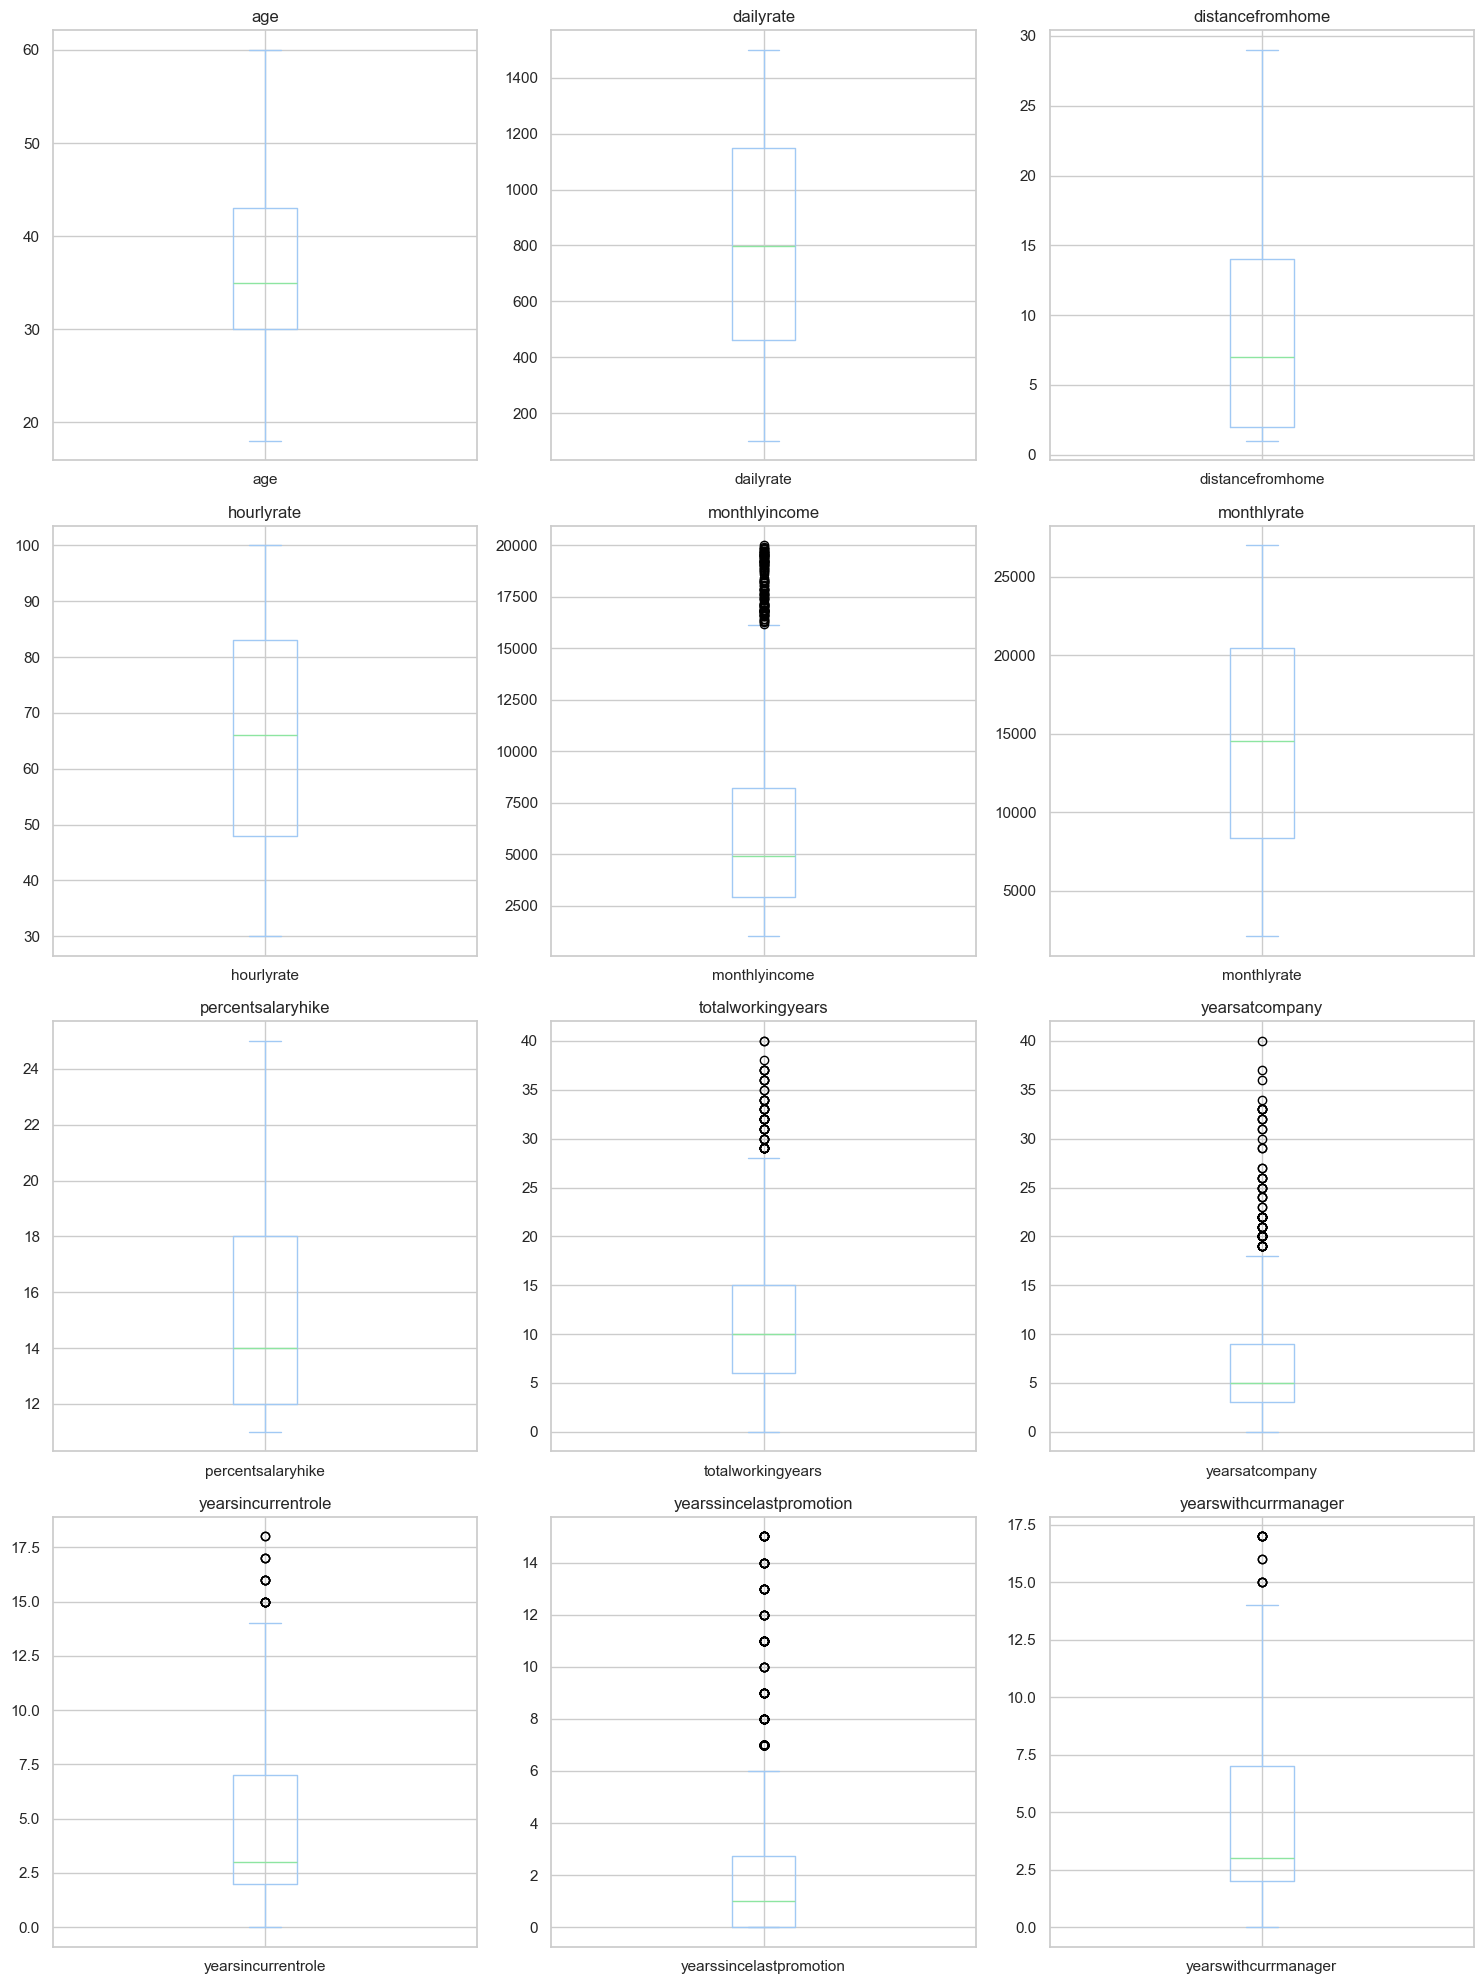

In [246]:
# Generate box plot for all numerical variable columns
create_boxplots(df)


### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [247]:
# Impute the outliers with 25% and 75% percentile values for the lower and higher values respectively


def treat_outliers(df_):
    print(numerical_columns)
    for col in numerical_columns:
        Q1 = df_[col].quantile(0.25)
        Q3 = df_[col].quantile(0.75)
        lower_fence = Q1 - 1.5 * (Q3 - Q1)
        upper_fence = Q3 + 1.5 * (Q3 - Q1)

        df_[col] = df_[col].apply(
            lambda x: Q1 if x < lower_fence else (Q3 if x > upper_fence else x)
        )
    return df_


df = treat_outliers(df)


['age', 'dailyrate', 'distancefromhome', 'hourlyrate', 'monthlyincome', 'monthlyrate', 'percentsalaryhike', 'totalworkingyears', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']


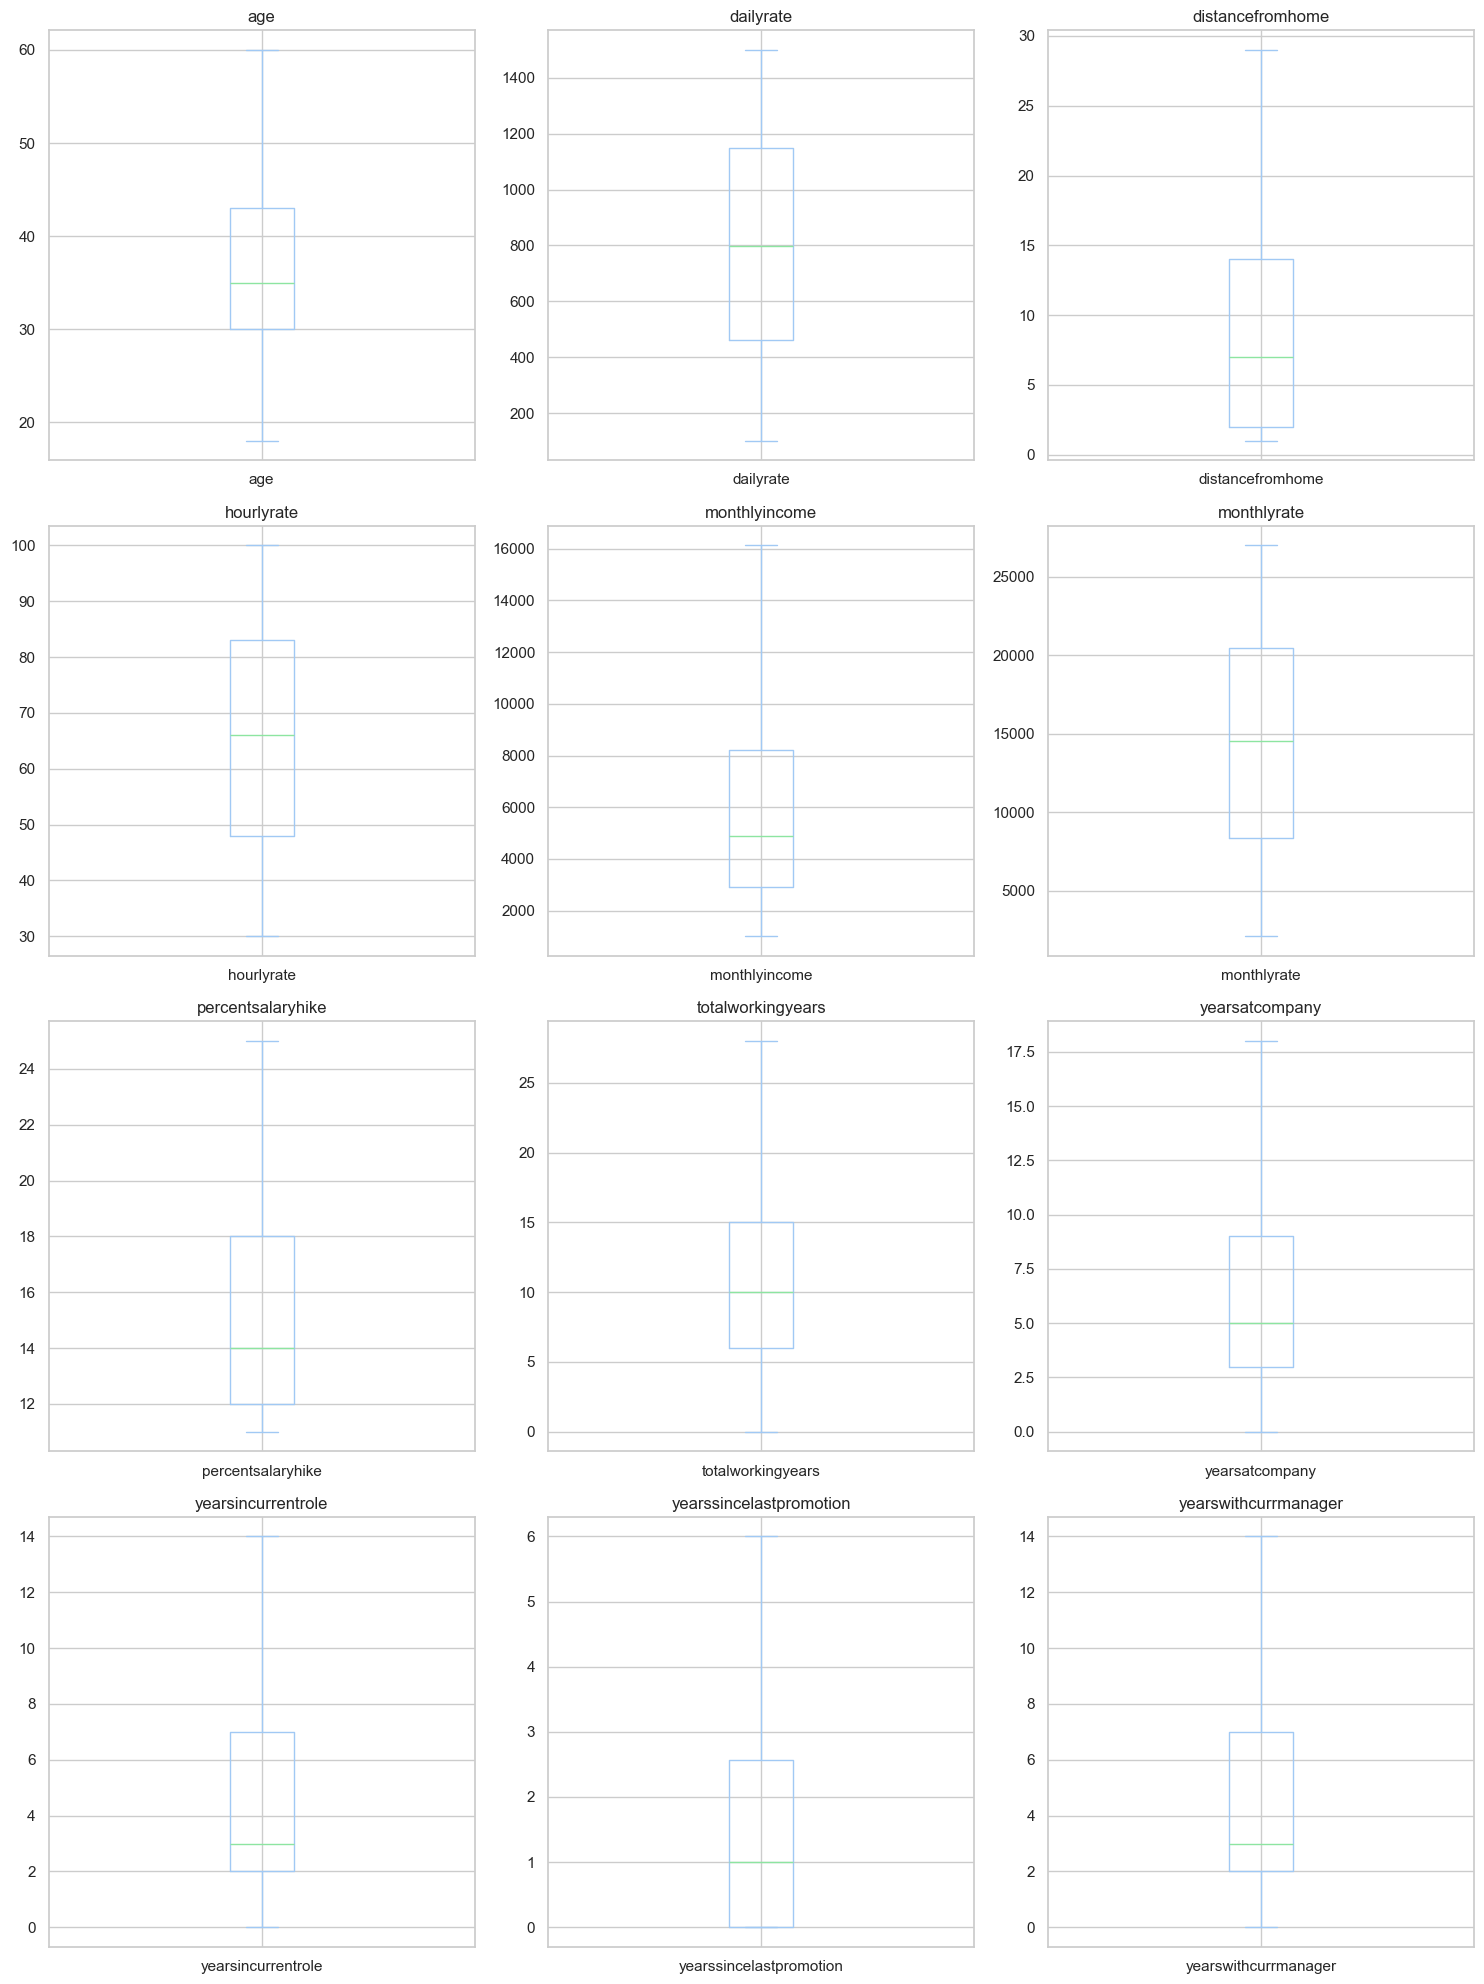

In [248]:
# Recheck for outliers
create_boxplots(df)


### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [249]:
# Count of unique values in Attrition column
total_attrition_count = df["attrition"].value_counts()
print(total_attrition_count)


attrition
No     981
Yes    189
Name: count, dtype: int64


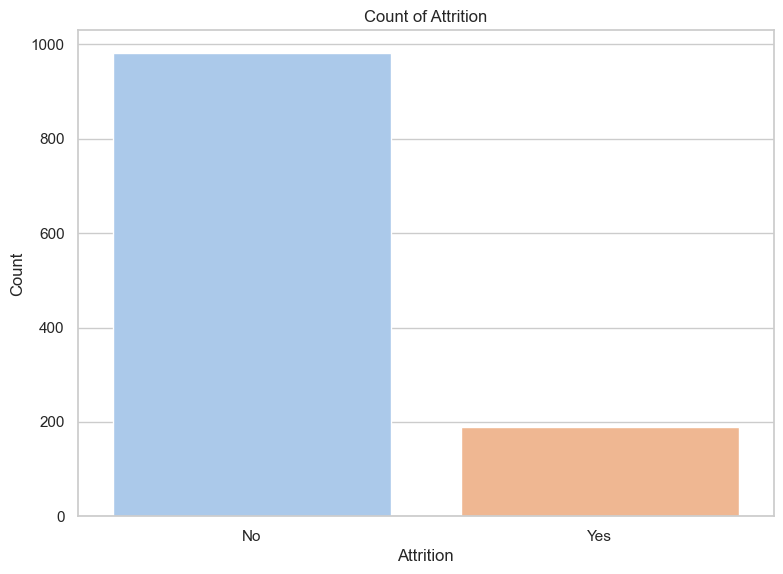

In [250]:
# Plot bar plot to visualize the count of attrition
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="attrition", palette="pastel")
plt.title("Count of Attrition")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.show()


If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

### Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

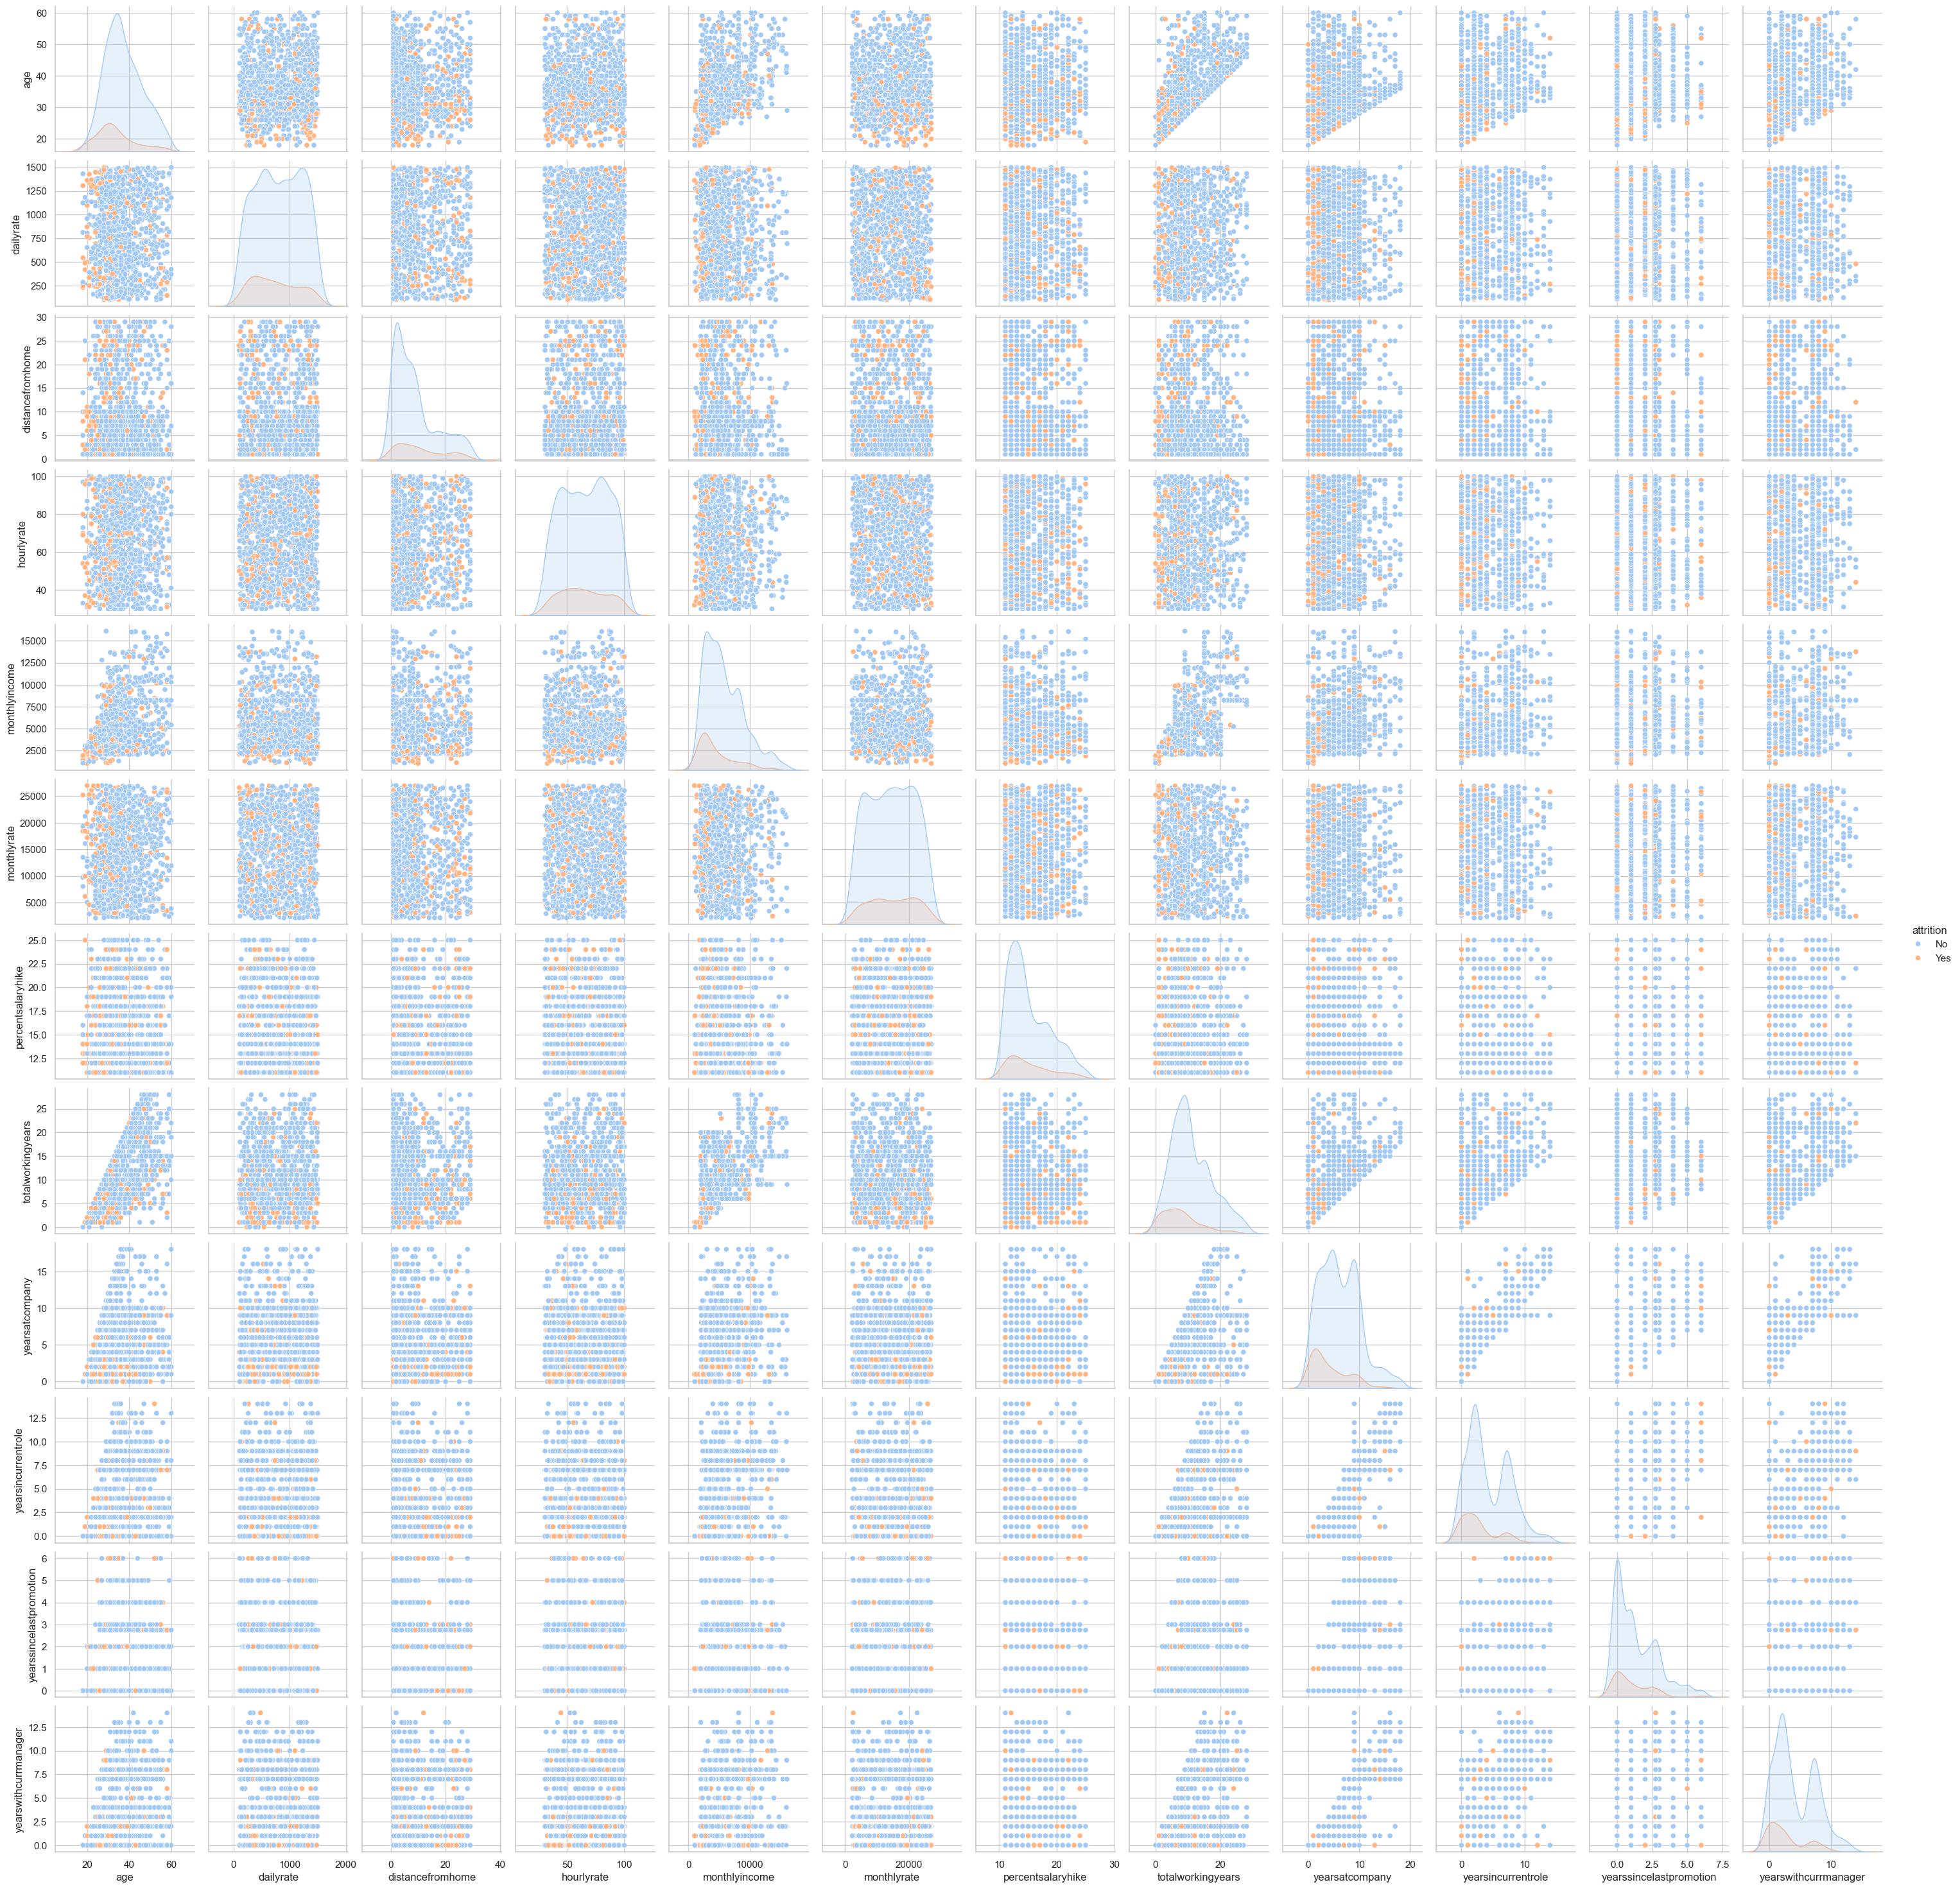

In [251]:
# Visualize a pairplot with relevant features
sns.pairplot(df, hue="attrition", vars=numerical_columns, palette="pastel")
plt.show()


In [252]:
# Visualize a pair plot with categorical features

# sns.pairplot(df, hue="attrition", vars=categorical_columns, palette="pastel")
# plt.show()


### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

In [253]:
def drop_columns(df_, categorical_columns, col_to_drop):
    # drop useless and unwanted columns
    # col_to_drop = useless_columns + ["over18", "standardhours"]
    df_temp = df_.drop(col_to_drop, axis=1)

    # trimming categorical_columns array too
    for item in col_to_drop:
        categorical_columns = [val for val in categorical_columns if val != item]

    print(f"Number of columns dropped: {len(col_to_drop)}")
    print(f"Columns dropped: {col_to_drop}")
    print(f"Number of remaining Categorical features: {len(categorical_columns)}")
    print(f"Categorical_columns: {categorical_columns}")
    return df_temp, categorical_columns


In [254]:
df, categorical_columns_new = drop_columns(
    df_=df,
    categorical_columns=categorical_columns_in_seq,
    col_to_drop=useless_col_to_drop,
)


Number of columns dropped: 4
Columns dropped: ['employeecount', 'employeenumber', 'over18', 'standardhours']
Number of remaining Categorical features: 19
Categorical_columns: ['businesstravel', 'department', 'education', 'educationfield', 'environmentsatisfaction', 'gender', 'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction', 'maritalstatus', 'numcompaniesworked', 'overtime', 'performancerating', 'relationshipsatisfaction', 'stockoptionlevel', 'trainingtimeslastyear', 'worklifebalance', 'attrition']


In [255]:
# encoding the categorical columns
df[categorical_columns_new] = df[categorical_columns_new].apply(
    lambda col: col.astype("category").cat.codes
)


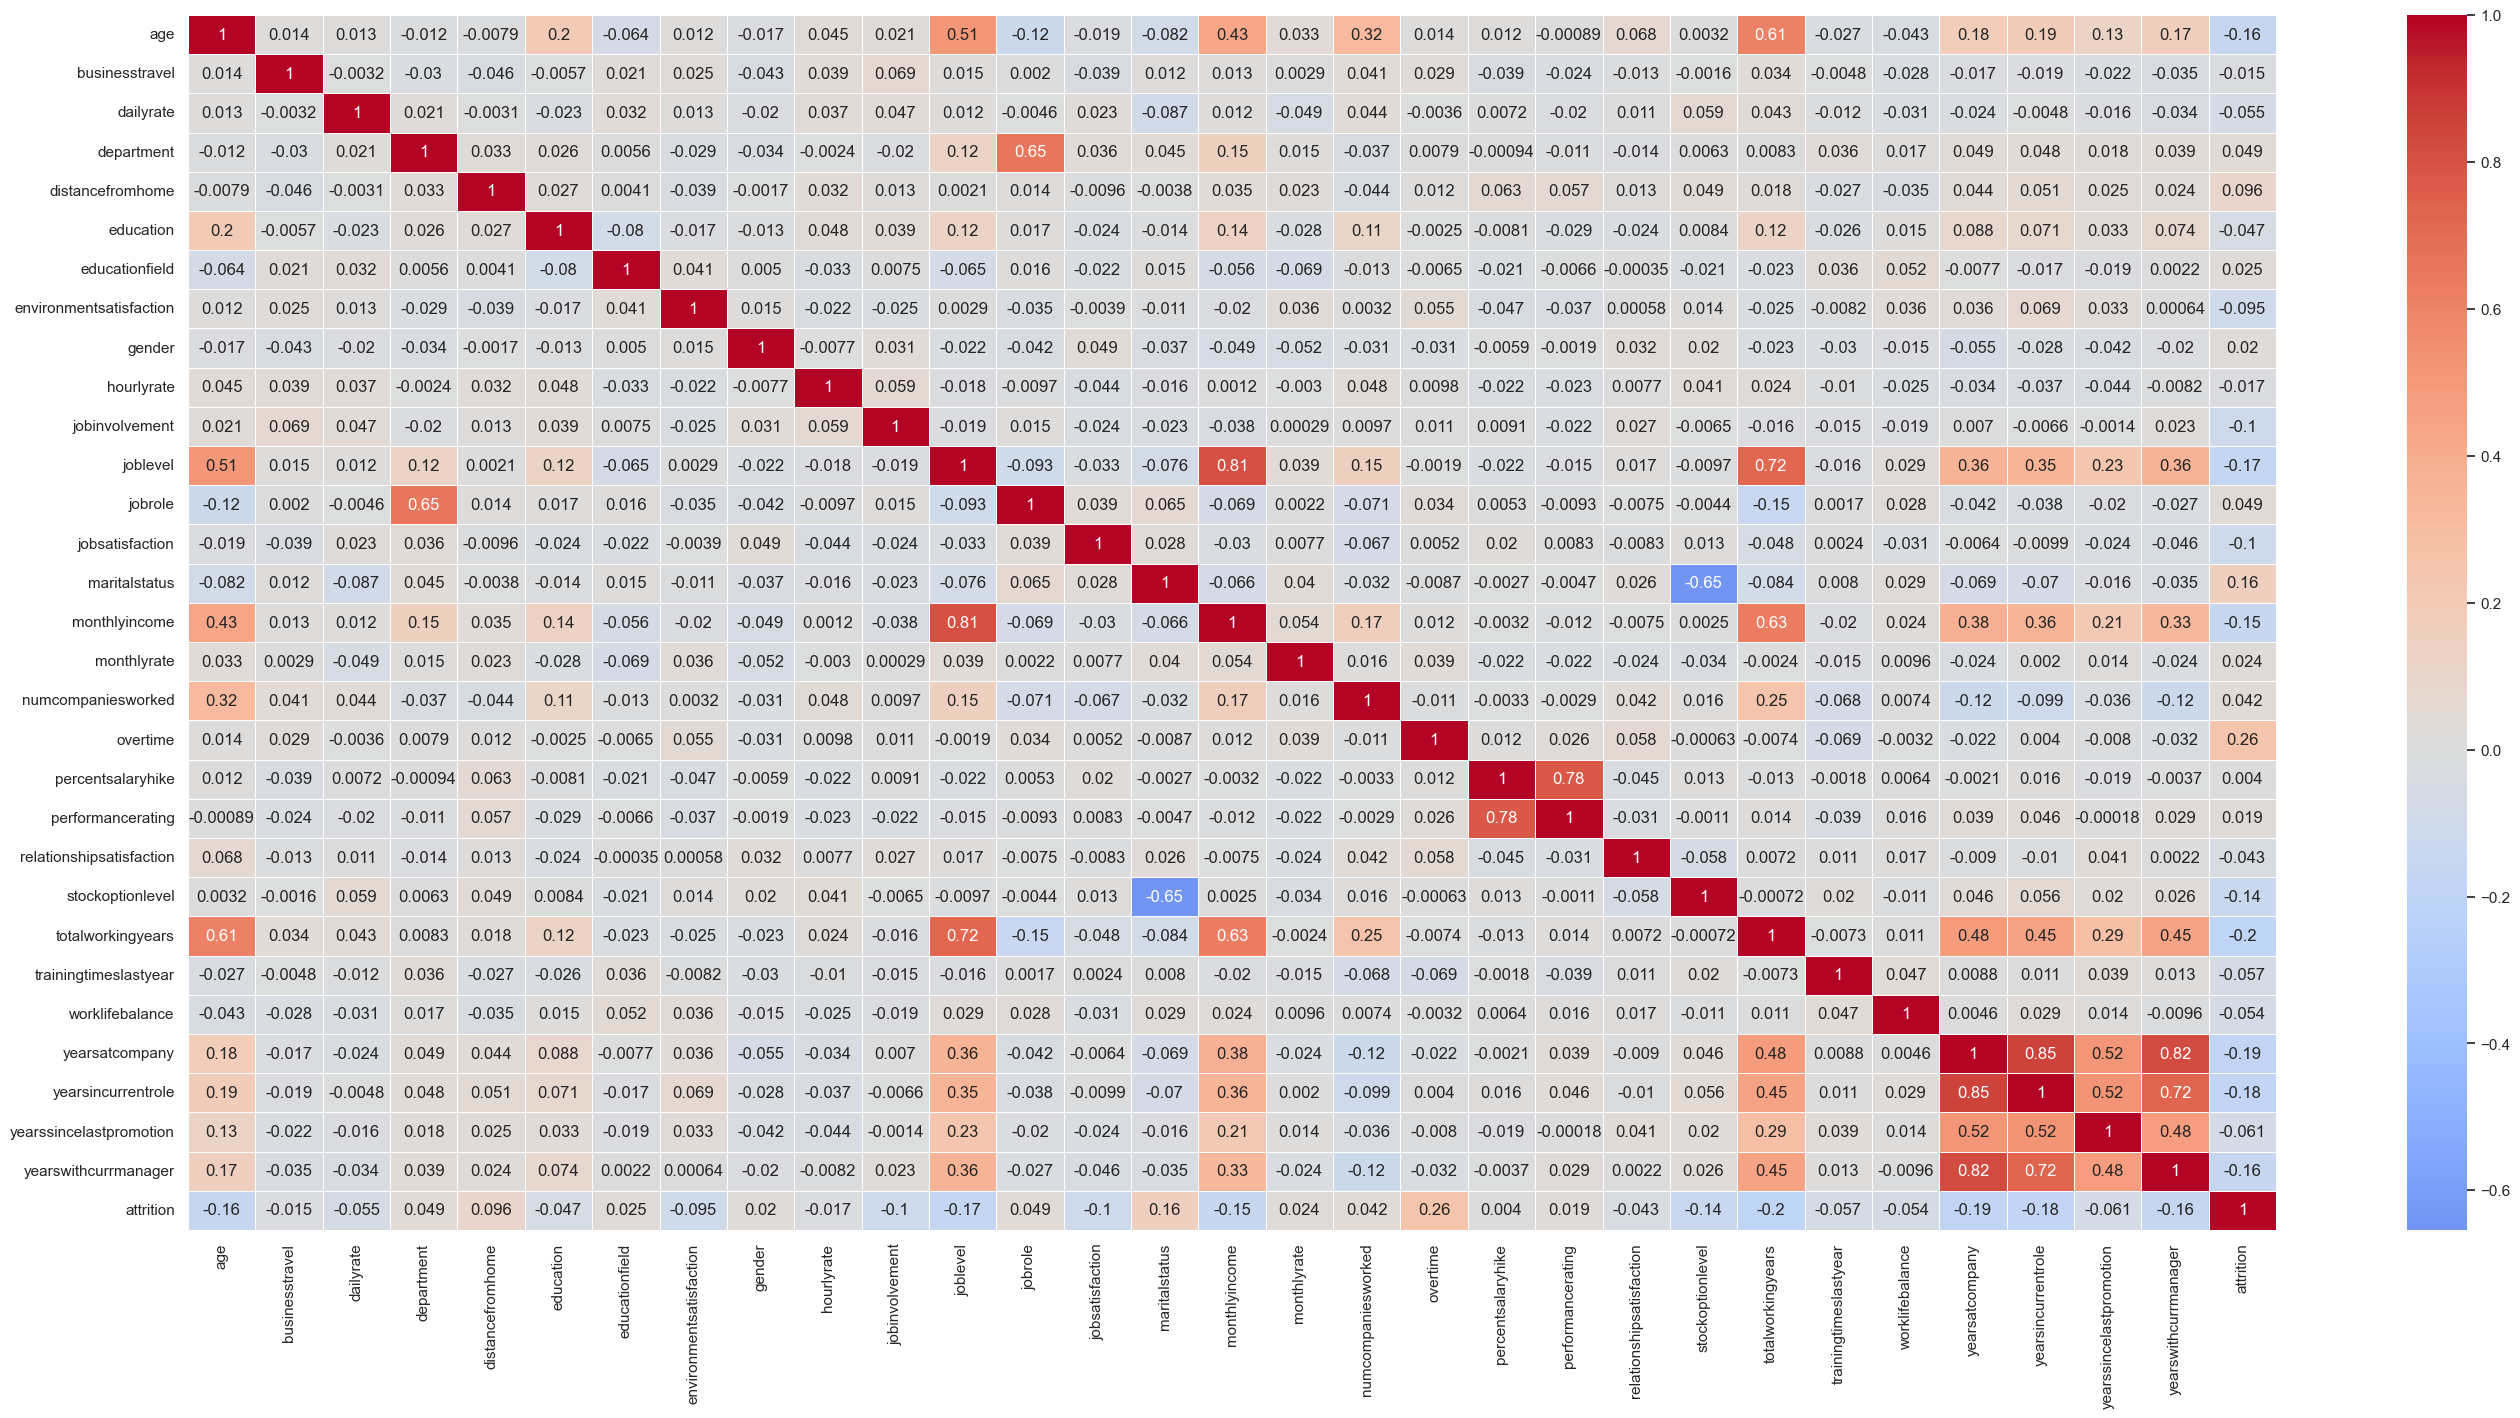

In [256]:
# plot the heat map
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(30, 15))
sns.heatmap(df.corr(), annot=True, linewidth=0.5, center=0, cmap="coolwarm")
plt.show()


### Analysis TODO
Comment on the observations made with the pairplot and heatmap

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [257]:
df = df_original.copy(deep=True)
df.shape


(1170, 35)

In [258]:
df.sample(n=10)


age     businesstravel  dailyrate              department  \
941    38      Travel_Rarely        168  Research & Development   
759    50  Travel_Frequently        562                   Sales   
472    29  Travel_Frequently        459  Research & Development   
723    37      Travel_Rarely       1017  Research & Development   
639    53      Travel_Rarely       1376                   Sales   
273    48      Travel_Rarely        626  Research & Development   
808    22      Travel_Rarely        594  Research & Development   
1010   41      Travel_Rarely        263  Research & Development   
389    42      Travel_Rarely        635                   Sales   
181    36      Travel_Rarely        216  Research & Development   

      distancefromhome  education    educationfield  employeecount  \
941                  1          3     Life Sciences              1   
759                  8          2  Technical Degree              1   
472                 24          2     Life Sciences              1   
723                  1          2           Medical              1   
639                  2          2           Medical              1   
273                  1          2     Life Sciences              1   
808                  2          1  Technical Degree              1   
1010                 6          3           Medical              1   
389                  1          1     Life Sciences              1   
181                  6          2           Medical              1   

      employeenumber  environmentsatisfaction  gender  hourlyrate  \
941              743                        3  Female          81   
759              723                        2    Male          50   
472             1868                        4    Male          73   
723              340                        3  Female          83   
639              981                        3    Male          45   
273               64                        1    Male          98   
808              169                        3    Male         100   
1010             957                        4    Male          59   
389              387                        2    Male          99   
181              178                        2    Male          84   

      jobinvolvement  joblevel                 jobrole  jobsatisfaction  \
941                3         3  Manufacturing Director                3   
759                3         2         Sales Executive                3   
472                2         1      Research Scientist                4   
723                2         1      Research Scientist                1   
639                3         4                 Manager                3   
273                2         3   Laboratory Technician                3   
808                3         1   Laboratory Technician                4   
1010               3         1   Laboratory Technician                1   
389                3         2         Sales Executive                3   
181                3         2  Manufacturing Director                2   

     maritalstatus  monthlyincome  monthlyrate  numcompaniesworked over18  \
941         Single           7861        15397                   4      Y   
759        Married           6796        23452                   3      Y   
472         Single           2439        14753                   1      Y   
723        Married           3920        18697                   2      Y   
639       Divorced          14852        13938                   6      Y   
273         Single           5381        19294                   9      Y   
808        Married           2523        19299                   0      Y   
1010        Single           4721         3119                   2      Y   
389        Married           4907        24532                   1      Y   
181       Divorced           4941         2819                   6      Y   

     overtime  percentsalaryhike  performancerating  relationsh

In [259]:
# remove outlier
df = treat_outliers(df_=df)
print(df.shape)


['age', 'dailyrate', 'distancefromhome', 'hourlyrate', 'monthlyincome', 'monthlyrate', 'percentsalaryhike', 'totalworkingyears', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']
(1170, 35)


In [260]:
# drop columns
df, categorical_columns_trimmed = drop_columns(
    df_=df,
    categorical_columns=categorical_columns_in_seq,
    col_to_drop=useless_col_to_drop,
)
categorical_columns_trimmed.remove("attrition")

print(f"shape: {df.shape} column list: {len(categorical_columns_trimmed)}")


Number of columns dropped: 4
Columns dropped: ['employeecount', 'employeenumber', 'over18', 'standardhours']
Number of remaining Categorical features: 19
Categorical_columns: ['businesstravel', 'department', 'education', 'educationfield', 'environmentsatisfaction', 'gender', 'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction', 'maritalstatus', 'numcompaniesworked', 'overtime', 'performancerating', 'relationshipsatisfaction', 'stockoptionlevel', 'trainingtimeslastyear', 'worklifebalance', 'attrition']
shape: (1170, 31) column list: 18


In [261]:
# encode ordinal and nominal categorical variables
# TODO Not needed for catboost model


Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

Refer to the Additional Notebook: CatBoost parameter tuning [CDS-B8 GDrive -> Module 3 -> Assignments -> July 27, 2024 -> Additional Notebook (ungraded) -> Addl_NB_Tuning_hyerparameters_using_Hyperopt]

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [262]:
# Copy the data
df_catboost = df.copy(deep=True)


In [263]:
# Target Column
y = df_catboost["attrition"]
y


0        No
1        No
2       Yes
3        No
4        No
       ... 
1165     No
1166     No
1167     No
1168     No
1169     No
Name: attrition, Length: 1170, dtype: object

In [264]:
# Feature Space
X = df_catboost.drop("attrition", axis=1)
X


age     businesstravel  dailyrate              department  \
0      45      Travel_Rarely        556  Research & Development   
1      34      Travel_Rarely        970  Research & Development   
2      39      Travel_Rarely        360  Research & Development   
3      26      Travel_Rarely        933                   Sales   
4      40      Travel_Rarely        329  Research & Development   
...   ...                ...        ...                     ...   
1165   47         Non-Travel       1169  Research & Development   
1166   48      Travel_Rarely        530                   Sales   
1167   36  Travel_Frequently        469  Research & Development   
1168   46         Non-Travel        849                   Sales   
1169   58      Travel_Rarely       1145  Research & Development   

      distancefromhome  education    educationfield  environmentsatisfaction  \
0                   25          2     Life Sciences                        2   
1                    8          2           Medical                        2   
2                   23          3           Medical                        3   
3                    1          3     Life Sciences                        3   
4                    1          4     Life Sciences                        2   
...                ...        ...               ...                      ...   
1165                14          4  Technical Degree                        3   
1166                29          1           Medical                        1   
1167                 3          3  Technical Degree                        3   
1168                26          2     Life Sciences                        2   
1169                 9          3           Medical                        2   

      gender  hourlyrate  jobinvolvement  joblevel                    jobrole  \
0     Female          93               2         2     Manufacturing Director   
1     Female          96               3         2  Healthcare Representative   
2       Male          93               3         1         Research Scientist   
3       Male          57               3         2            Sales Executive   
4       Male          88               3         1      Laboratory Technician   
...      ...         ...             ...       ...                        ...   
1165    Male          64               3         2         Research Scientist   
1166  Female          91               3         3                    Manager   
1167    Male          46               3         1         Research Scientist   
1168    Male          98               2         2            Sales Executive   
1169  Female          75               2         1         Research Scientist   

      jobsatisfaction maritalstatus  monthlyincome  monthlyrate  \
0                   4       Married         5906.0        23888   
1                   3        Single         6142.0         7360   
2                   1        Single         3904.0        22154   
3                   3       Married         5296.0        20156   
4                   2       Married         2387.0         6762   
...               ...           ...            ...          ...   
1165                2       Married         5467.0         2125   
1166                3       Married        12504.0        23978   
1167                2       Married         3692.0         9256   
1168                2        Single         7991.0        25166   
1169                2       Married         3346.0        11873   

      numcompaniesworked overtime  percentsalaryhike  performancerating  \
0                      0       No                 13                  3   
1                      3       No                 11                  3   
2                      0       No                 13                  3   
3                      1       No                 17                  3   
4                      3       No                 22                  4   
...         

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [265]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=123
)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((936, 30), (936,), (234, 30), (234,))

In [266]:
# check the imbalance
y_train.value_counts()


attrition
No     785
Yes    151
Name: count, dtype: int64

In [267]:
# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {
    cls: weight for cls, weight in zip(np.unique(y_train), class_weights)
}


In [268]:
# Create CatBoost model
CatBoost_clf = CatBoostClassifier(
    cat_features=categorical_columns_trimmed,
    iterations=200,
    learning_rate=0.2,
    random_state=123,
    # max_depth=8,
    class_weights=class_weights_dict,
    # auto_class_weights="Balanced",
    # loss_function="CrossEntropy"
)


In [269]:
# Model training
CatBoost_clf.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=False,
)


In [270]:
y_cbr_prediction = CatBoost_clf.predict(x_test)


In [271]:
print("Accuracy Score: ", accuracy_score(y_true=y_test, y_pred=y_cbr_prediction))
print("f1 score:", f1_score(y_true=y_test, y_pred=y_cbr_prediction, pos_label="Yes"))


Accuracy Score:  0.8589743589743589
f1 score: 0.611764705882353


In [272]:
print("Classification Report for CatBoost:")
print(classification_report(y_true=y_test, y_pred=y_cbr_prediction))


Classification Report for CatBoost:
              precision    recall  f1-score   support

          No       0.94      0.89      0.91       196
         Yes       0.55      0.68      0.61        38

    accuracy                           0.86       234
   macro avg       0.74      0.79      0.76       234
weighted avg       0.87      0.86      0.86       234



### Model performance

In [273]:
# giniDecisionTree = DecisionTreeClassifier(
#     criterion="gini",
#     random_state=123,
#     max_depth=3,
#     class_weight="balanced",
#     min_samples_leaf=10,
# )
# giniDecisionTree.fit(x_train, y_train)


In [274]:
# Prediction using DecisionTree
# giniPred = giniDecisionTree.predict(x_test)
# print("Accuracy Score: ", accuracy_score(y_test, giniPred))
# print("f1 score:", f1_score(y_test, giniPred))


In [299]:
# Model performance on all sets


In [279]:
# write a code to test the model trained above


## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [280]:
# Copy dataframe
df_xgboost = df.copy(deep=True)
print(df_xgboost.shape)


(1170, 31)


In [281]:
df_xgboost["attrition"] = df_xgboost["attrition"].map({"Yes": 1, "No": 0})


**Hint:** Use pd.get_dummies

In [282]:
# trim the categorical variables
print(f"Useless columns to drop: {useless_col_to_drop}")
print(
    f"Before -> Ordinal: {len(categorical_ordinal_columns)} Nominal: {len(categorical_nominal_columns)}"
)
categorical_ordinal_columns_trimmed = [
    item for item in categorical_ordinal_columns if item not in useless_col_to_drop
]
categorical_nominal_columns_trimmed = [
    item for item in categorical_nominal_columns if item not in useless_col_to_drop
]

categorical_nominal_columns_trimmed.remove("attrition")

print(
    f"After -> Ordinal: {len(categorical_ordinal_columns_trimmed)} Nominal: {len(categorical_nominal_columns_trimmed)}"
)


Useless columns to drop: ['employeecount', 'employeenumber', 'over18', 'standardhours']
Before -> Ordinal: 11 Nominal: 10
After -> Ordinal: 11 Nominal: 7


In [283]:
# Handling categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("ord", OrdinalEncoder(), categorical_ordinal_columns_trimmed),
#         # ("nom", OneHotEncoder(), categorical_nominal_columns_trimmed),
#     ],
#     remainder="passthrough",
# )
# col_l = df_xgboost.columns.to_list()

# df_transformed = preprocessor.fit_transform(df_xgboost)
# df_transformed.shape
# df_transformed = pd.DataFrame(df_transformed, columns=col_l)
# df_transformed.shape


In [284]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(
    df_xgboost[categorical_nominal_columns_trimmed]
)


In [285]:
df_with_encoded_features = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(categorical_nominal_columns_trimmed),
)
df_with_encoded_features.head(5)


businesstravel_Non-Travel  businesstravel_Travel_Frequently  \
0                        0.0                               0.0   
1                        0.0                               0.0   
2                        0.0                               0.0   
3                        0.0                               0.0   
4                        0.0                               0.0   

   businesstravel_Travel_Rarely  department_Human Resources  \
0                           1.0                         0.0   
1                           1.0                         0.0   
2                           1.0                         0.0   
3                           1.0                         0.0   
4                           1.0                         0.0   

   department_Research & Development  department_Sales  \
0                                1.0               0.0   
1                                1.0               0.0   
2                                1.0               0.0   
3                                0.0               1.0   
4                                1.0               0.0   

   educationfield_Human Resources  educationfield_Life Sciences  \
0                             0.0                           1.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           1.0   
4                             0.0                           1.0   

   educationfield_Marketing  educationfield_Medical  educationfield_Other  \
0                       0.0                     0.0                   0.0   
1                       0.0                     1.0                   0.0   
2                       0.0                     1.0                   0.0   
3                       0.0                     0.0                   0.0   
4                       0.0                     0.0                   0.0   

   educationfield_Technical Degree  gender_Female  gender_Male  \
0                              0.0            1.0          0.0   
1                              0.0            1.0          0.0   
2                              0.0            0.0          1.0   
3                              0.0            0.0          1.0   
4                              0.0            0.0          1.0   

   jobrole_Healthcare Representative  jobrole_Human Resources  \
0                                0.0                      0.0   
1                                1.0                      0.0   
2                                0.0                      0.0   
3                                0.0                      0.0   
4                                0.0                      0.0   

   jobrole_Laboratory Technician  jobrole_Manager  \
0                            0.0              0.0   
1                            0.0              0.0   
2                            0.0              0.0   
3                            0.0              0.0   
4                            1.0              0.0   

   jobrole_Manufacturing Director  jobrole_Research Director  \
0                             1.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   jobrole_Research Scientist  jobrole_Sales Executive  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         1.0                      0.0   
3                         0.0                      1.0   
4                         0.0                      0.0   

   jobrole_Sales Representative  maritalstatus_Divorced  \
0                           0.0                     0.0   
1                           0.0                     0

In [286]:
df_encoded = pd.concat(
    [
        df_xgboost[numerical_columns],
        df_xgboost[categorical_ordinal_columns_trimmed],
        df_with_encoded_features,
        df_xgboost["attrition"],
    ],
    axis=1,
)
df_encoded.head(5)


age  dailyrate  distancefromhome  hourlyrate  monthlyincome  monthlyrate  \
0   45        556                25          93         5906.0        23888   
1   34        970                 8          96         6142.0         7360   
2   39        360                23          93         3904.0        22154   
3   26        933                 1          57         5296.0        20156   
4   40        329                 1          88         2387.0         6762   

   percentsalaryhike  totalworkingyears  yearsatcompany  yearsincurrentrole  \
0                 13               10.0             9.0                 8.0   
1                 11               10.0             5.0                 1.0   
2                 13                6.0             5.0                 2.0   
3                 17                8.0             8.0                 7.0   
4                 22                7.0             4.0                 2.0   

   yearssincelastpromotion  yearswithcurrmanager  education  \
0                     3.00                   8.0          2   
1                     4.00                   3.0          2   
2                     0.00                   3.0          3   
3                     2.75                   7.0          3   
4                     0.00                   3.0          4   

   environmentsatisfaction  jobinvolvement  joblevel  jobsatisfaction  \
0                        2               2         2                4   
1                        2               3         2                3   
2                        3               3         1                1   
3                        3               3         2                3   
4                        2               3         1                2   

   numcompaniesworked  performancerating  relationshipsatisfaction  \
0                   0                  3                         4   
1                   3                  3                         4   
2                   0                  3                         1   
3                   1                  3                         2   
4                   3                  4                         3   

   stockoptionlevel  trainingtimeslastyear  worklifebalance  \
0                 2                      2                2   
1                 0                      2                3   
2                 0                      2                3   
3                 1                      3                3   
4                 1                      3                3   

   businesstravel_Non-Travel  businesstravel_Travel_Frequently  \
0                        0.0                               0.0   
1                        0.0                               0.0   
2                        0.0                               0.0   
3                        0.0                               0.0   
4                        0.0                               0.0   

   businesstravel_Travel_Rarely  department_Human Resources  \
0                           1.0                         0.0   
1                           1.0                         0.0   
2                           1.0                         0.0   
3                           1.0                         0.0   
4                           1.0                         0.0   

   department_Research & Development  department_Sales  \
0                                1.0               0.0   
1                                1.0               0.0   
2                                1.0               0.0   
3                                0.0               1.0   
4                                1.0               0.0   

   educationfield_Human Resources  educationfield_Life Sciences  \
0                             0.0                           1.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0         

In [287]:
# Apply the transformations
y = df_encoded["attrition"]
X = df_encoded.drop(columns="attrition", axis=1)
print(y.shape, X.shape)


(1170,) (1170, 51)


In [288]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE


When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [289]:
# Rename target column
# YOUR CODE HERE


In [290]:
# Feature Space
# YOUR CODE HERE

# Targer label
# YOUR CODE HERE


In [291]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=123
)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((936, 51), (936,), (234, 51), (234,))

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [292]:
y_train.value_counts()


attrition
0    785
1    151
Name: count, dtype: int64

In [293]:
# calculate the weight multiplier for the minority. This is passed to the classifier object.
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
scale_pos_weight


5.198675496688741

In [294]:
# another way to create sample weights. This is passed to the .fit function
class_weights = {0: 1, 1: np.sum(y_train == 0) / np.sum(y_train == 1)}
sample_weights = np.array([class_weights[y] for y in y_train])
sample_weights


array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       5.1986755, 5.1986755, 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 5.1986755, 1.       , 1.       , 5.1986755,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 5.1986755, 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 5.1986755,
       1.       , 5.1986755, 1.       , 5.1986755, 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       5.1986755, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 5.1986755, 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 

In [295]:
# Create XGBoost classifier model

XGB_clf = XGBClassifier(
    learning_rate=0.09,
    n_estimators=200,
    max_depth=5,
    gamma=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=123,
)


In [296]:
# Model training

XGB_clf.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train)],
    sample_weight=sample_weights,
    verbose=False,
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

### Model Performance

In [297]:
# Model performance on all sets
y_XGB_prediction = XGB_clf.predict(x_test)
print("Accuracy Score: ", accuracy_score(y_true=y_test, y_pred=y_XGB_prediction))
print("f1 score:", f1_score(y_true=y_test, y_pred=y_XGB_prediction))


Accuracy Score:  0.9145299145299145
f1 score: 0.7142857142857143


In [298]:
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_XGB_prediction))


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       196
           1       0.78      0.66      0.71        38

    accuracy                           0.91       234
   macro avg       0.86      0.81      0.83       234
weighted avg       0.91      0.91      0.91       234



## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [ ]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
# YOUR CODE HERE

# Handling categorical features
# YOUR CODE HERE

# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

# Rename target column
# YOUR CODE HERE

# Features Space
# YOUR CODE HERE

# Target Label
# YOUR CODE HERE


### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [ ]:
# Create LightGBM classifier model
# YOUR CODE HERE


In [ ]:
# Model training
# YOUR CODE HERE


### Model performance

In [ ]:
# Model performance on all sets
# YOUR CODE HERE


## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [ ]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE


Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

## Kaggle Prediction

Load data from Kaggle competition site

In [ ]:
# From the given Kaggle competition link, load the dataset 'hr_employee_attrition_test.csv'
# YOUR CODE HERE

df_test = pd.read_csv("hr_employee_attrition_test.csv")
df_test_original = df_test.copy(deep=True)
df_test = treat_outliers(df_test)


In [ ]:
# From the dataset 'hr_employee_attrition_test.csv', drop columns ['id','employeenumber', 'employeecount', 'over18'] having single value
# YOUR CODE HERE
df_test.drop(useless_columns + ["over18", "standardhours", "id"], axis=1, inplace=True)


In [ ]:
# Handle categorical features
# YOUR CODE HERE
print(df_test.columns, df_test.shape)


In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE


Predictions

In [ ]:
# Get the predictions using your already trained CatBoost classifier model achieved in Exercise 9
# YOUR CODE HERE


In [ ]:
# Get the predictions using your already trained XGBoost classifier model achieved in Exercise 11
# YOUR CODE HERE


Get the predictions using your trained Microsoft LightGBM model (Optional)

In [ ]:
# Get the predictions using your already trained Microsoft LightGBM classifier model
# achieved under the optional exercise 'Apply LightGBM (Optional)'
# YOUR CODE HERE


Save predictions to csv and submit under given Kaggle competiton link

In [ ]:
# YOUR CODE HERE
